In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import torch
import torchvision
from torchvision import models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [2]:
import os
# Define dataset path
dataset_path = "/content/drive/MyDrive"
annotation_train = os.path.join(dataset_path, 'annotation', 'instances_train2017.json')
annotation_val = os.path.join(dataset_path, 'annotation', 'instances_val2017.json')


In [3]:
# Define albumentations
def get_albumentation(train):
    if train:
        return A.Compose([
            A.Resize(500,500),
            A.HorizontalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(300, 300),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [4]:
from pycocotools.coco import COCO

# Define function to find unique classes and count
def find_unique_classes_and_count(annotation_file):
    coco = COCO(annotation_file)
    categories = coco.loadCats(coco.getCatIds())
    category_dict = {cat['id']: cat['name'] for cat in categories}
    return category_dict, len(category_dict)

# Example usage:
classes, n_classes = find_unique_classes_and_count(annotation_train)

print(f"Unique classes and their IDs: {classes}")
print(f"Number of unique classes: {n_classes}")




class_id_map = {original_id: new_id for new_id, original_id in enumerate(classes)}


loading annotations into memory...
Done (t=1.27s)
creating index...
index created!
Unique classes and their IDs: {1: 'echinus', 2: 'starfish', 3: 'holothurian', 4: 'scallop'}
Number of unique classes: 4


In [5]:

from torchvision import datasets
class UTDACDetection(datasets.VisionDataset):
    def __init__(self, root, annotation_file, transforms=None):
        super(UTDACDetection, self).__init__(root, transforms=transforms)
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)  # Load COCO annotations

        # Load image ids
        self.img_ids = self.coco.getImgIds()
        self.imgs = [self.coco.loadImgs(img_id)[0]['file_name'] for img_id in self.img_ids]

    def __getitem__(self, idx):
        # Get image id
        img_id = self.img_ids[idx]

        # Load image
        img_path = os.path.join(self.root, self.imgs[idx])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Load annotations for the image
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            # Convert bbox from [x, y, width, height] to [x_min, y_min, x_max, y_max]
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = bbox[0] + bbox[2]
            y_max = bbox[1] + bbox[3]
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id_map[ann['category_id']])  # Map original class ID to new class ID

        # Correct invalid bounding boxes
        corrected_boxes = []
        for bbox in boxes:
            x_min, y_min, x_max, y_max = bbox
            if x_max <= x_min:
                x_min, x_max = x_max, x_min
            if y_max <= y_min:
                y_min, y_max = y_max, y_min
            corrected_boxes.append([x_min, y_min, x_max, y_max])

        # Create target dictionary
        boxes = torch.as_tensor(corrected_boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        # Apply transformations
        if self.transforms is not None:
            transformed = self.transforms(image=img_rgb, bboxes=target['boxes'], labels=labels)
            img_rgb = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        return img_rgb, target

    def __len__(self):
        return len(self.imgs)



In [9]:
train_dataset = UTDACDetection(root=os.path.join(dataset_path, 'Filtered_images_2'), annotation_file=annotation_train, transforms=get_albumentation(True))

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [10]:
import numpy as np
dataset_size = len(train_dataset)
subset_size = dataset_size // 2

indices = list(range(dataset_size))
np.random.shuffle(indices)

from torch.utils.data import Dataset, DataLoader, Subset
subset_indices = indices[:subset_size]
train_subset = Subset(train_dataset, subset_indices)

In [11]:
len(train_subset)

2584

In [12]:
# Function to display image with bounding boxes
def display_image_with_boxes(dataset, idx):
    img, target = dataset[idx]
    img = img.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)
    for box in target['boxes']:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()


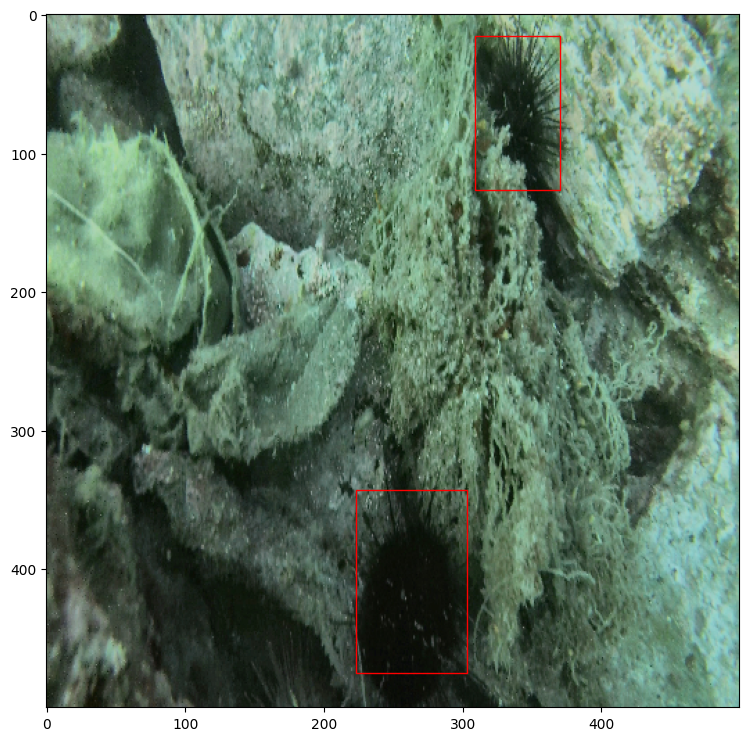

In [13]:
display_image_with_boxes(train_subset, 0)

In [14]:
# Verify dataset format
def verify_dataset(dataset, idx):
    img, target = dataset[idx]
    assert isinstance(img, torch.Tensor), "Image should be a tensor"
    assert isinstance(target, dict), "Target should be a dictionary"
    assert "boxes" in target, "Target should contain 'boxes'"
    assert "labels" in target, "Target should contain 'labels'"
    assert img.shape[0] == 3, "Image should have 3 color channels"
    print(f"Image shape: {img.shape}")
    print(f"Boxes: {target['boxes']}")
    print(f"Labels: {target['labels']}")

In [15]:
verify_dataset(train_subset, 0)

Image shape: torch.Size([3, 500, 500])
Boxes: tensor([[196.6146, 342.5926, 277.2135, 474.5370],
        [129.5573,  15.2778, 191.1458, 125.9259]])
Labels: tensor([0, 0])


In [16]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 74.1MB/s]


In [17]:
# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [18]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [19]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [21]:
from tqdm import tqdm
import math
import sys
import torch
import pandas as pd
import numpy as np

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    header = f'Epoch: [{epoch}]'

    lr_scheduler = None
    if epoch == 0:
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(data_loader, desc=header):
        images = [image.to(device) for image in images]
        targets = [{k: v.clone().detach().to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print(f"Epoch {epoch}: lr: {optimizer.param_groups[0]['lr']:.6f}, "
          f"loss: {np.mean(all_losses):.6f}, "
          f"loss_classifier: {all_losses_dict['loss_classifier'].mean():.6f}, "
          f"loss_box_reg: {all_losses_dict['loss_box_reg'].mean():.6f}, "
          f"loss_rpn_box_reg: {all_losses_dict['loss_rpn_box_reg'].mean():.6f}, "
          f"loss_objectness: {all_losses_dict['loss_objectness'].mean():.6f}")


In [22]:

# Prepare the DataLoader
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# Example usage
num_epochs = 20
import time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for epoch in range(num_epochs):
    epoch_start_time=time.time()

    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    epoch_time=time.time()-epoch_start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

    ##save the model and optimizer
    torch.save({
        'epoch':epoch,
         'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),

    },f'/content/drive/MyDrive/checkpoint_epoch_{epoch}.pth')



print("Training completed")

Epoch: [0]: 100%|██████████| 646/646 [48:01<00:00,  4.46s/it]


Epoch 0: lr: 0.005000, loss: 0.443467, loss_classifier: 0.177004, loss_box_reg: 0.164524, loss_rpn_box_reg: 0.023826, loss_objectness: 0.078113
Epoch 0 completed in 2881.56 seconds


Epoch: [1]: 100%|██████████| 646/646 [09:10<00:00,  1.17it/s]


Epoch 1: lr: 0.005000, loss: 0.355324, loss_classifier: 0.127913, loss_box_reg: 0.154330, loss_rpn_box_reg: 0.020326, loss_objectness: 0.052754
Epoch 1 completed in 550.28 seconds


Epoch: [2]: 100%|██████████| 646/646 [09:08<00:00,  1.18it/s]


Epoch 2: lr: 0.005000, loss: 0.324111, loss_classifier: 0.112839, loss_box_reg: 0.151382, loss_rpn_box_reg: 0.018774, loss_objectness: 0.041117
Epoch 2 completed in 548.07 seconds


Epoch: [3]: 100%|██████████| 646/646 [09:09<00:00,  1.18it/s]


Epoch 3: lr: 0.000500, loss: 0.270725, loss_classifier: 0.090381, loss_box_reg: 0.135964, loss_rpn_box_reg: 0.016139, loss_objectness: 0.028242
Epoch 3 completed in 549.79 seconds


Epoch: [4]: 100%|██████████| 646/646 [09:08<00:00,  1.18it/s]


Epoch 4: lr: 0.000500, loss: 0.263724, loss_classifier: 0.087642, loss_box_reg: 0.133965, loss_rpn_box_reg: 0.015758, loss_objectness: 0.026359
Epoch 4 completed in 548.43 seconds


Epoch: [5]: 100%|██████████| 646/646 [09:06<00:00,  1.18it/s]


Epoch 5: lr: 0.000500, loss: 0.256482, loss_classifier: 0.084191, loss_box_reg: 0.131820, loss_rpn_box_reg: 0.015575, loss_objectness: 0.024896
Epoch 5 completed in 546.67 seconds


Epoch: [6]:  72%|███████▏  | 464/646 [06:34<02:35,  1.17it/s]

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Faster_rcnn_model_UTDAC1.pth')

In [ ]:
from tqdm import tqdm
import math
import sys
import torch
import pandas as pd
import numpy as np

def train_one_epoch1(model, optimizer, data_loader, device, epoch):
    model.train()
    header = f'Epoch: [{epoch}]'

    lr_scheduler = None
    if epoch == 0:
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(data_loader, desc=header):
        images = [image.to(device) for image in images]
        targets = [{k: v.clone().detach().to(device) for k, v in t.items()} for t in targets]

        # Ensure the model and optimizer are on the correct device
        model.to(device)
        for param in model.parameters():
            param.grad = None

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print(f"Epoch {epoch}: lr: {optimizer.param_groups[0]['lr']:.6f}, "
          f"loss: {np.mean(all_losses):.6f}, "
          f"loss_classifier: {all_losses_dict['loss_classifier'].mean():.6f}, "
          f"loss_box_reg: {all_losses_dict['loss_box_reg'].mean():.6f}, "
          f"loss_rpn_box_reg: {all_losses_dict['loss_rpn_box_reg'].mean():.6f}, "
          f"loss_objectness: {all_losses_dict['loss_objectness'].mean():.6f}")

# Example usage:
# Ensure the model and optimizer are on the correct device before calling the function
# model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
# train_one_epoch1(model, optimizer, train_loader, device, epoch)


In [ ]:
torch.save(model.state_dict(), 'Faster_rcnn_model.pth')

In [ ]:

model.load_state_dict(torch.load('Faster_rcnn_model.pth'))

In [3]:
#for resuming training where training is stoped due to runtime access
#checkpoint=torch.load('/content/drive/MyDrive/checkpoint_epoch_2.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch=checkpoint['epoch']+1

continue training
num_epochs=20
for epoch in range(start_epoch,num_epochs):
    epoch_start_time=time.time()

    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    epoch_time=time.time()-epoch_start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

    ##save the model and optimizer
    torch.save({
        'epoch':epoch,
         'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),

    },f'/content/drive/MyDrive/checkpoint_epoch_{epoch}.pth')



print("Training completed")

In [ ]:
import torch
from torchvision import models
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
import time
def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    all_gt_boxes = []
    all_pred_boxes = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].to('cpu')
                scores = output['scores'].to('cpu')
                labels = output['labels'].to('cpu')

                all_pred_boxes.append(pred_boxes)
                all_scores.append(scores)
                all_labels.append(labels)

                gt_boxes = targets[i]['boxes'].to('cpu')
                all_gt_boxes.append(gt_boxes)

    # Compute mAP
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for gt_boxes, pred_boxes, scores in zip(all_gt_boxes, all_pred_boxes, all_scores):
        if len(pred_boxes) == 0:
            false_negatives += len(gt_boxes)
            continue

        if len(gt_boxes) == 0:
            false_positives += len(pred_boxes)
            continue

        ious = box_iou(pred_boxes, gt_boxes)

        for i, score in enumerate(scores):
            if score >= 0.5:
                iou_max, _ = torch.max(ious[i], dim=0)
                if iou_max >= iou_threshold:
                    true_positives += 1
                else:
                    false_positives += 1

        false_negatives += len(gt_boxes) - torch.sum(ious.max(dim=0)[0] >= iou_threshold).item()

    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)

    mean_ap = 2 * (precision * recall) / (precision + recall + 1e-6)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mean_ap:.4f}")

# Measure the time taken
start_time = time.time()

# Evaluate the model
evaluate_model(model, val_loader, device)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")